This notebook generates Figures S5 b, c, and d.

In [1]:
import anndata
import scvi
import scanpy as sc
import numpy as np
import pandas as pd
import sc_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sc.set_figure_params(figsize=(12, 12))
sc.set_figure_params(vector_friendly = False)

/home/kjs6397/.conda/envs/pasc_revisions_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import sys
path = os.getcwd()
sys.path.insert(0, "/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/lib")
import sankey

In [3]:
mpl.font_manager.fontManager.addfont(f"/projects/b1038/Pulmonary/nmarkov/2022-script-atlas/code//fonts/Arial.ttf")

mpl.rcParams["font.family"] = "Arial"

In [4]:
sc.set_figure_params(fontsize = 15)

### Load object

In [5]:
DIR = "/projects/b1038/Pulmonary/cpuritz/PASC/data/21scArches/reyfman_reprocessed"

In [6]:
adata = sc.read_h5ad(f"{DIR}/reyfman_reprocessed.h5ad")

### Rename clusters

In [7]:
rename_map = {'MoAM-1': 'MP1', 
              'MoAM-2': 'MP2',
              'TRAM-1': 'MP3',
              'TRAM-2': 'MP4',
              'TRAM-3': 'MP5',
              'Perivascular MoAM': 'MP6',
              'Proliferating T cells': 'Prolif. T cells',
              'Alveolar proliferating macrophages': 'Alveolar prolif. macrophages',
              'Interstitial proliferating macrophages': 'Interstitial prolif. macrophages',
              'Proliferating epithelial cells': 'Prolif. epithelial cells',
              "CD4 T cells": r"$\mathregular{{CD4}^+}$T cells",
              "CD8 T cells": r"$\mathregular{{CD8}^+}$T cells",
              "Tregs": r"$\mathregular{{T_{reg}}}$cells",
             }

adata.obs['cell_type_pred'] = adata.obs['cell_type_pred'].map(rename_map).fillna(adata.obs['cell_type_pred'])

In [8]:
adata.obs['cell_type_pred'].unique().tolist()

['AT2-2',
 'Alveolar prolif. macrophages',
 'MP5',
 'Fibroblasts',
 'Classical monocytes',
 'Prolif. epithelial cells',
 'Endothelial cells',
 'AT2-1',
 'Basal cells',
 'Transitional Club-AT2',
 'Lymphatics',
 'MP3',
 'MP1',
 'AT1',
 'Prolif. T cells',
 'Non-classical monocytes',
 'B cells',
 'MP6',
 'DC2',
 '$\\mathregular{{CD4}^+}$T cells',
 'Ciliated cells',
 'NK + gDT cells',
 'MP2',
 'DC1',
 'Plasma cells',
 'MP4',
 'Pericytes and smooth muscle cells',
 '$\\mathregular{{T_{reg}}}$cells',
 'Mast cells',
 'Interstitial prolif. macrophages',
 '$\\mathregular{{CD8}^+}$T cells',
 'Secretory cells',
 'Migratory DC',
 'pDC']

## Fig. S5B: UMAP

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

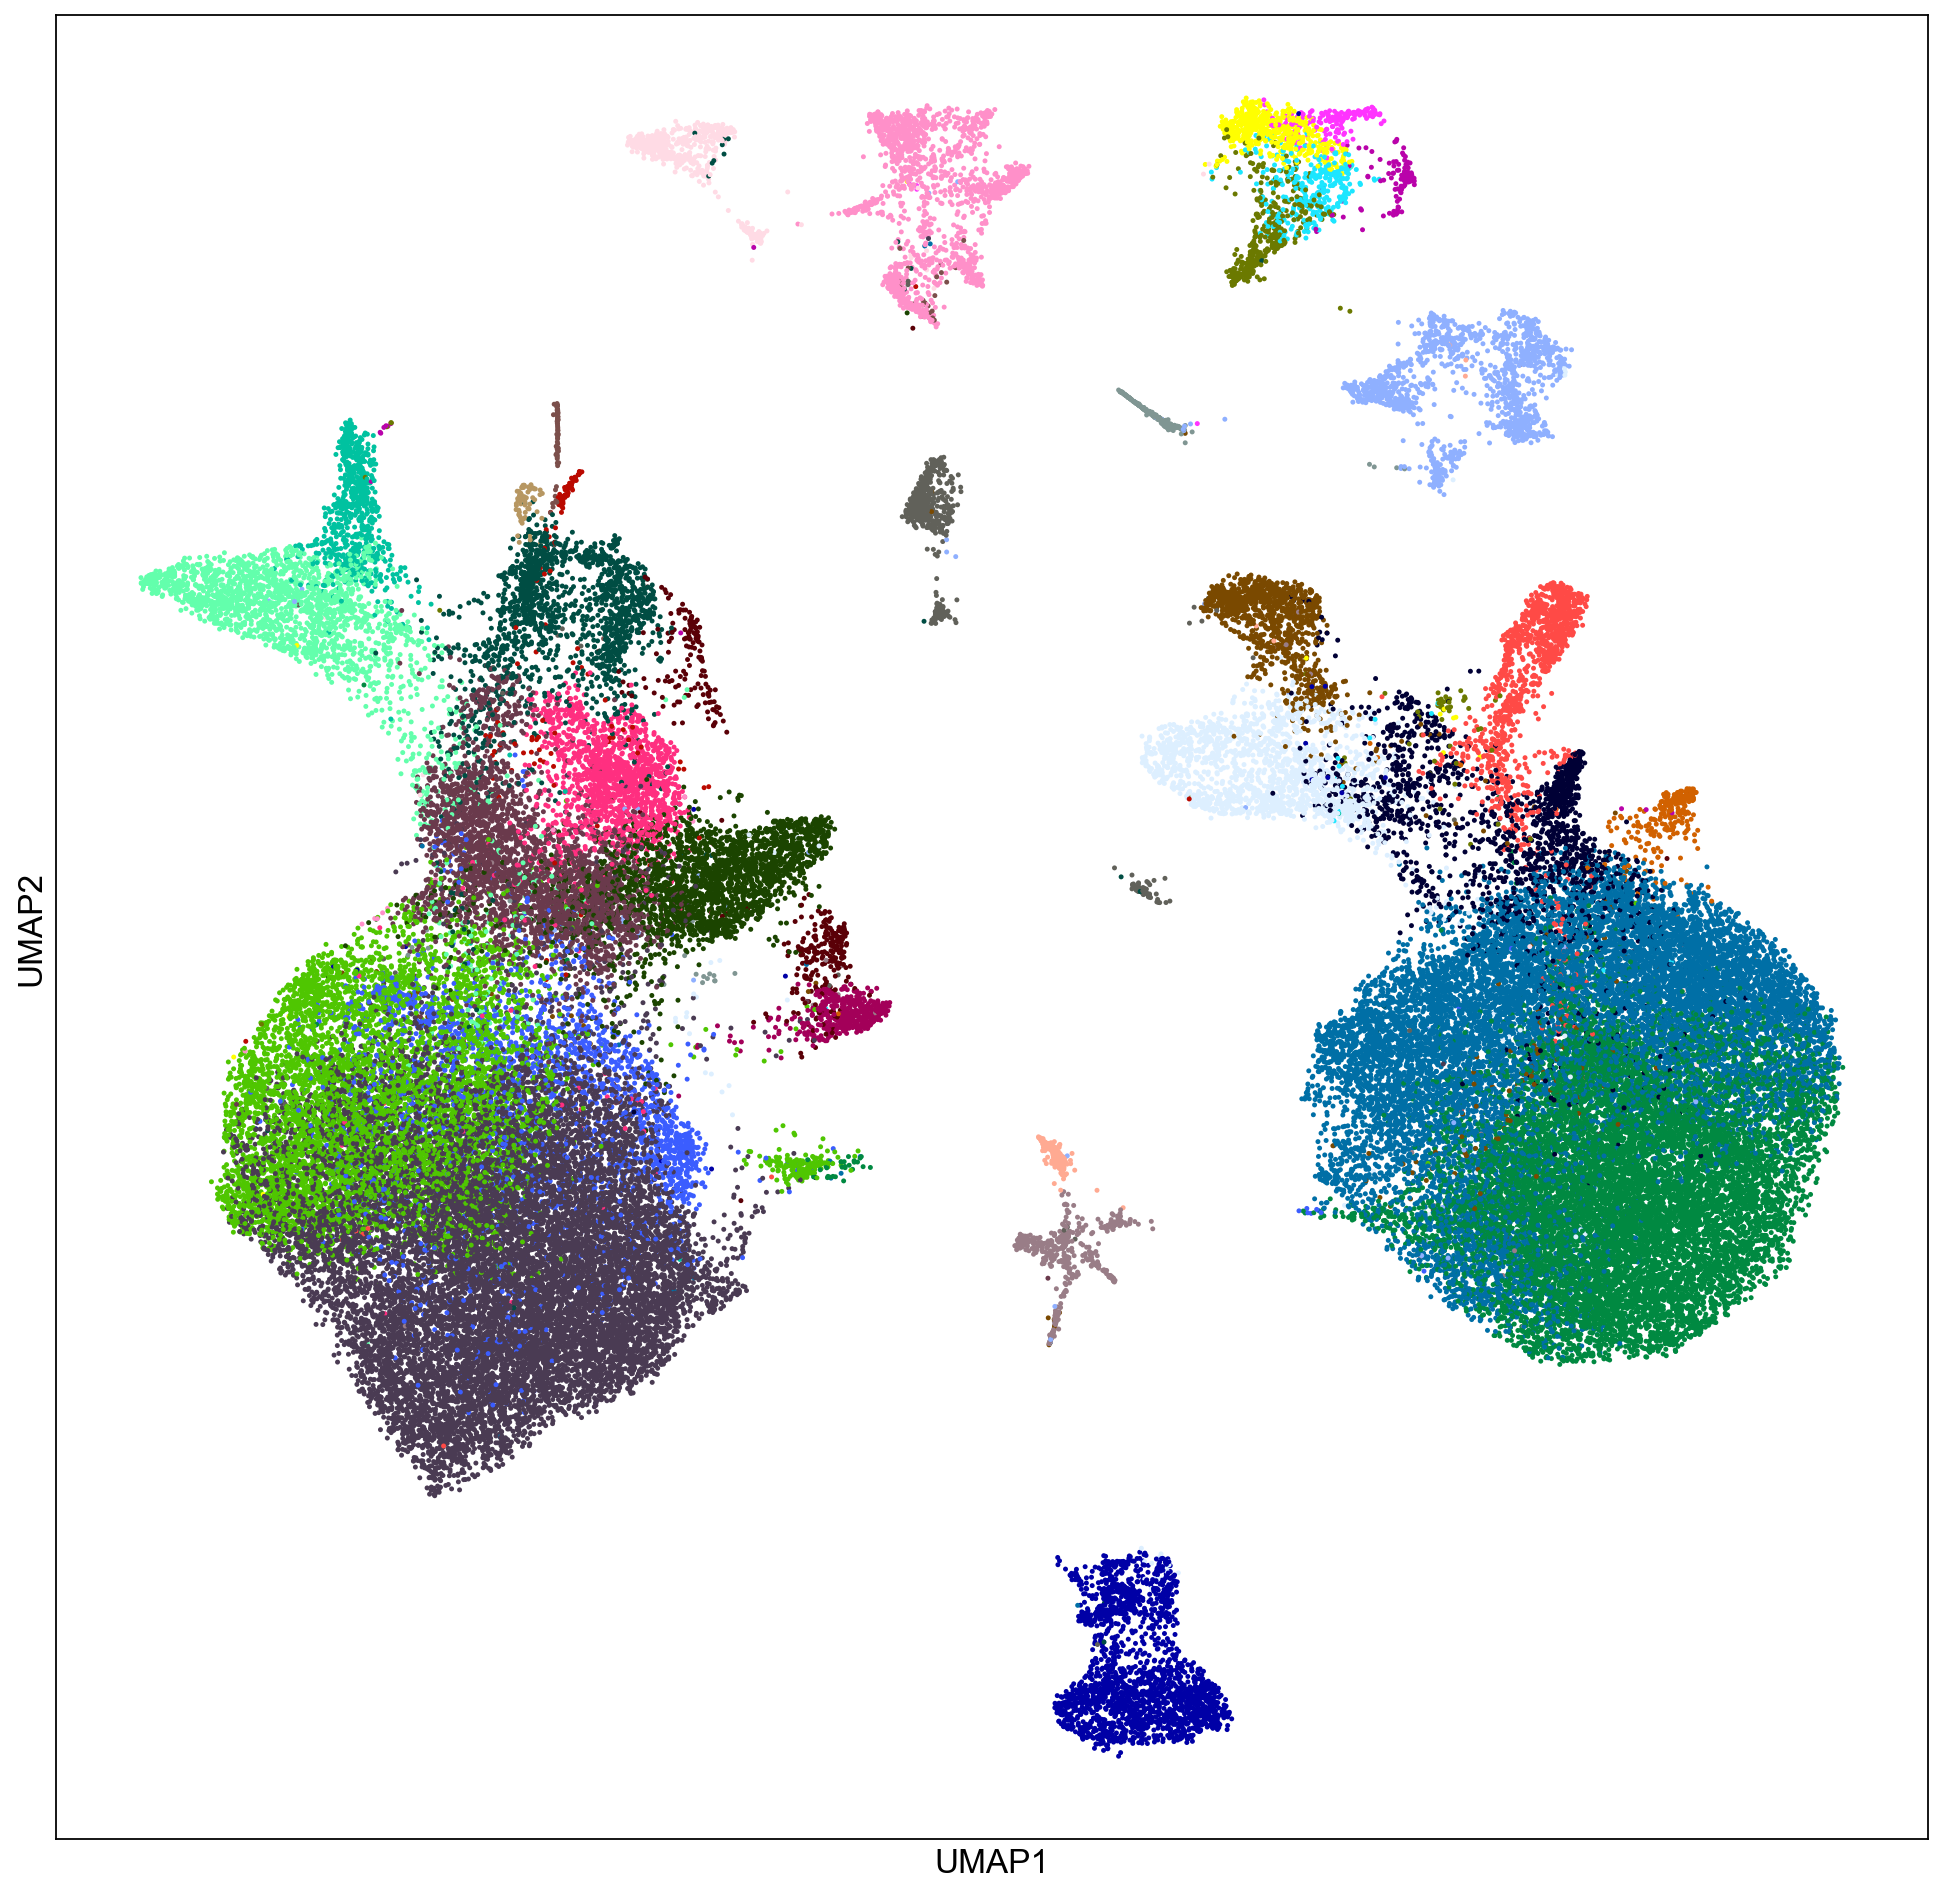

In [9]:
fig, ax = plt.subplots(figsize=(15, 15), constrained_layout=False) 
sc.pl.umap(
    adata, 
    color='cell_type_pred', 
    legend_loc=None, 
    ax=ax, 
    legend_fontoutline=3,
    legend_fontsize=12,
    show=False,
    size=20,
    title=''
)
ax.figure.savefig(f"/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/data/figures/fig_s5/fig_S5b.png", bbox_inches='tight')
ax.figure.savefig(f"/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/data/figures/fig_s5/fig_S5b.pdf", bbox_inches='tight')

## Fig. S5C: Uncertainty scores
Left column - cluster labels from Bailey et al. (MoAM-1, MoAM-2, etc). 

Right column - cluster labels projected from reannotated Reyfman (MP1, MP2, etc). 

Middle column - label transfer uncertainly scores per cell - this middle column will serve as a heatmap of how confident those predictions are.

### Import Bailey object

In [10]:
bailey = sc.read_h5ad('/projects/b1038/Pulmonary/cpuritz/PASC/data/01BAL/raw/adata_raw_final.h5ad')

### Import Reyfman projected on Bailey

In [11]:
reyf_on_bailey = sc.read_h5ad('/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/data/21scArches/reyfman_on_PASC/reyfman_on_PASC.h5ad')

In [12]:
rename_map = {'MoAM-1': 'MP1', 
              'MoAM-2': 'MP2',
              'TRAM-1': 'MP3',
              'TRAM-2': 'MP4',
              'TRAM-3': 'MP5',
              'Perivascular MoAM': 'MP6'
             }

reyf_on_bailey.obs['cell_type_pred'] = reyf_on_bailey.obs['cell_type_pred'].map(rename_map).fillna(reyf_on_bailey.obs['cell_type_pred'])

### Subset on common cells

In [13]:
common_indices = bailey.obs.index.intersection(reyf_on_bailey.obs.index)

bailey = bailey[common_indices, :]
reyf_on_bailey = reyf_on_bailey[common_indices, :]

### Create one dataframe

In [14]:
bailey.obs = bailey.obs[['cell_type']]
reyf_on_bailey.obs = reyf_on_bailey.obs[['cell_type_uncertainty', 'cell_type_pred']]

In [15]:
sankey_df = pd.merge(bailey.obs, reyf_on_bailey.obs, left_index=True, right_index=True)

In [16]:
sankey_df = sankey_df[(sankey_df.cell_type_pred.isin(['MP1', 'MP2', 'MP3', 'MP4', 'MP5', 'MP6'])) &
                     (sankey_df.cell_type.isin(['MoAM-1', 'MoAM-2', 'MoAM-3', 'MoAM-4',
                                               'TRAM-1', 'TRAM-2', 'TRAM-3', 'TRAM-4',
                                               'TRAM-5', 'Perivascular macrophages', 'Proliferating macrophages']))]

### Plot sankey

In [17]:
violin_plots = sankey_df[['cell_type_pred', 'cell_type_uncertainty']]

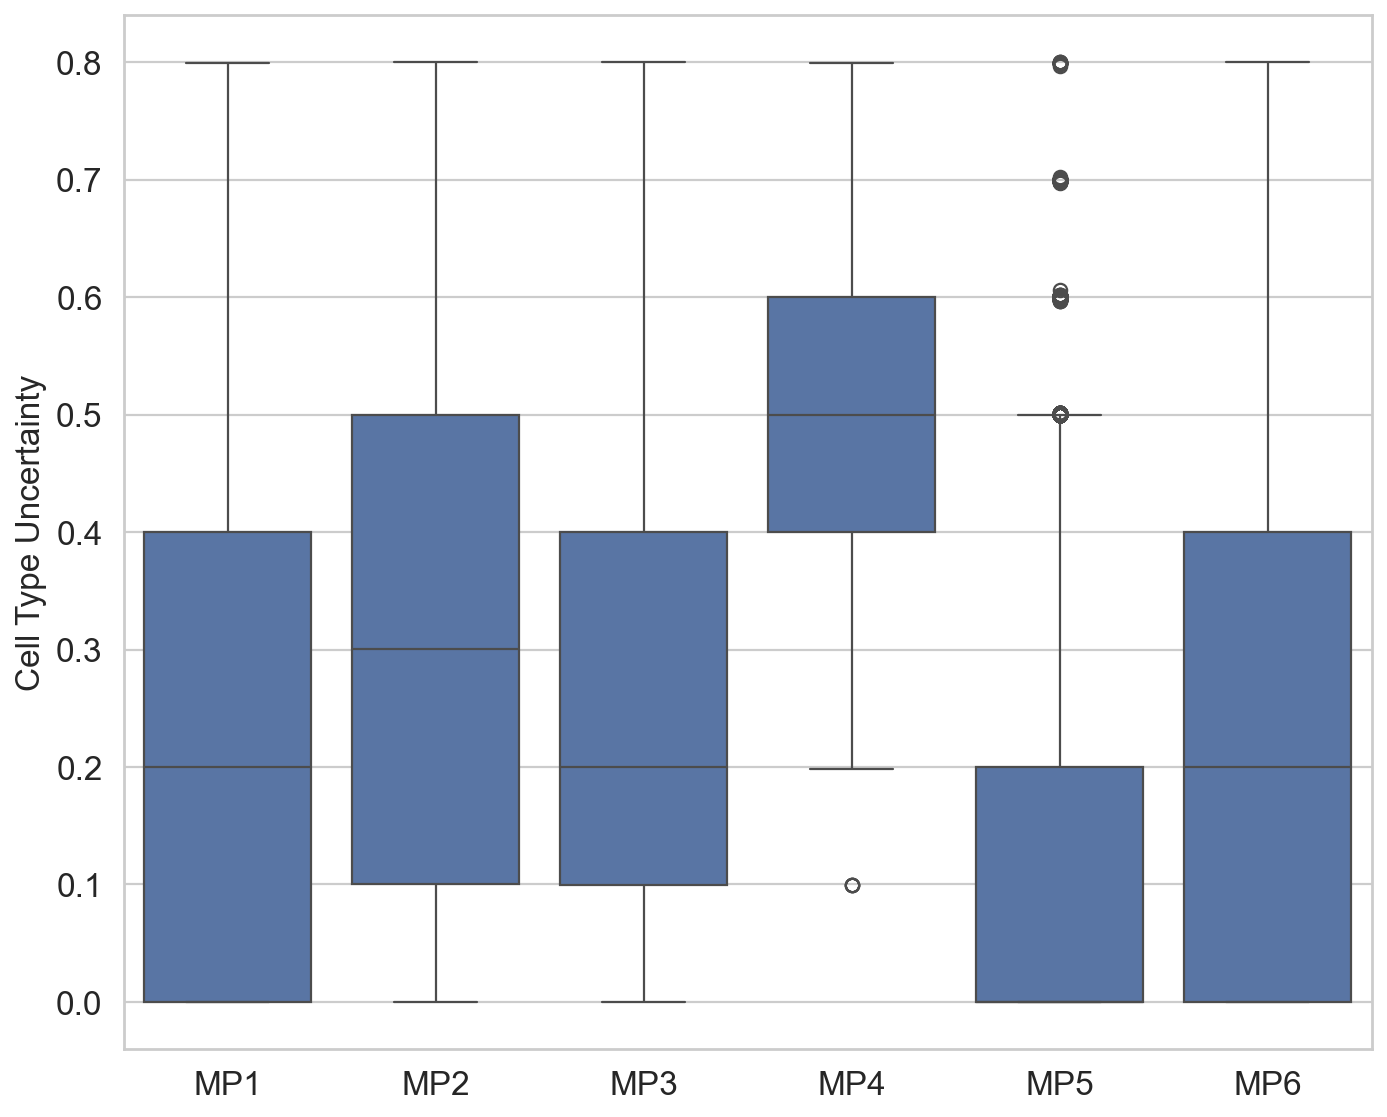

In [18]:
order = ['MP1', 'MP2', 'MP3', 'MP4', 'MP5', 'MP6']

sns.set(style="whitegrid")

plt.figure(figsize=(10, 8.5))
sns.boxplot(x="cell_type_pred", y="cell_type_uncertainty", data=violin_plots, order=order)
plt.title('')
plt.xlabel('')
plt.ylabel('Cell Type Uncertainty', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 

plt.savefig(f"/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/data/figures/fig_s5/fig_S5c.pdf", bbox_inches='tight')
plt.savefig(f"/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/data/figures/fig_s5/fig_S5c.png", bbox_inches='tight')
plt.show()
plt.close()

## Fig. S5D: Heatmap of top 5 marker genes for the new Reyfman object

In [19]:
def get_markers(
    adata,
    groupby,
    key="rank_genes_groups",
    p_val_cutoff=0.05,
    logfc_cutoff=0.5
):
    """\
    Extract markers from adata into Seurat-like table

    Extracts markers after they are computed by ``scanpy``. Produces Seurat-like
    table with fields
    ``"p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"``

    Calculates the percentage of cells that express a given gene
    in the target cluster (``pct.1`` field) and outside the cluster
    (``pct.2`` field) from ``adata.raw`` matrix.

    Parameters
    ----------
    adata
        Annotated data matrix.
    groupby
        ``adata.obs`` field used for marker calculation
    key
        ``adata.uns`` key that has computed markers
    p_val_cutoff
        Drop all genes with adjusted p-value greater than or equal to this
    logfc_cutoff
        Drop all genes with average logFC less than or equal to this

    Returns
    -------
    Returns a pandas dataframe with above listed columns, optionally
    subsetted on the genes that pass the cutoffs.
    ``p_val`` field is a copy of adjusted p-value field.

    Example
    -------
    >>> sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon", n_genes=200)
    >>> markers = sc_utils.get_markers(adata, "leiden")
    >>> markers.to_csv("markers.csv")
    """
    markers = pd.concat([
        pd.DataFrame(adata.uns[key]["names"]).melt(),
        pd.DataFrame(adata.uns[key]["pvals_adj"]).melt(),
        pd.DataFrame(adata.uns[key]["logfoldchanges"]).melt()
    ], axis=1)
    markers.columns = ("cluster", "gene", "cluster2", "p_val_adj", "cluster3", "avg_logFC")
    markers = markers.loc[:, ["cluster", "gene", "avg_logFC", "p_val_adj"]]
    markers = markers.loc[markers.avg_logFC > logfc_cutoff, ]
    markers = markers.loc[markers.p_val_adj < p_val_cutoff, ]
    markers["pct.1"] = pd.Series(dtype=float)
    markers["pct.2"] = pd.Series(dtype=float)

    for cluster in markers.cluster.unique():
        cells = adata.obs[groupby] == cluster
        in_cluster_selector = markers.cluster == cluster
        genes = markers.gene[in_cluster_selector]
        in_cluster = np.sum(adata.raw[cells, genes].X > 0, axis=0).A1 / cells.sum()
        markers.loc[in_cluster_selector, "pct.1"] = in_cluster
        other_cells = adata.obs[groupby] != cluster
        other_clusters = np.sum(adata.raw[other_cells, genes].X > 0, axis=0).A1 / other_cells.sum()
        markers.loc[in_cluster_selector, "pct.2"] = other_clusters

    markers["p_val"] = markers.p_val_adj
    markers = markers.loc[:, ["p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"]]
    return markers

### Get markers for predictions

In [20]:
sc.tl.rank_genes_groups(adata, "cell_type_pred", method="t-test", n_genes=200)

/home/kjs6397/.conda/envs/pasc_revisions_venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/kjs6397/.conda/envs/pasc_revisions_venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/kjs6397/.conda/envs/pasc_revisions_venv/lib/python3.9/site-packages/scanpy/tools/_ran

/home/kjs6397/.conda/envs/pasc_revisions_venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:444: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "pvals_adj"] = pvals_adj[global_indices]
/home/kjs6397/.conda/envs/pasc_revisions_venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/kjs6397/.conda/envs/pasc_revisions_venv/lib/python3.9/site-packages/scanpy/tools/_rank_genes

In [21]:
markers = get_markers(adata, "cell_type_pred")
markers.sort_values(["cluster", "avg_logFC"], ascending=[True, False], inplace=True)
markers = markers.groupby("cluster").head(5)

In [22]:
top_genes = markers.gene.unique().tolist()

In [23]:
top_genes_reordered = ['KRT5', 'MIR205HG', 'MMP1', 'S100A2', 'PTPRZ1', 'BPIFB1', 'CYP2F1', 'SCGB3A1', 'RHOV', 'ERN2', 'CEACAM6', 'CTSE', 'CLIC5', 'CAV1', 'ZBBX', 'ERICH3', 'C1orf194', 'C20orf85', 'SNTN', 'SFTPC', 'SFTPA1', 'SFTPA2', 'SFTPB', 'SLPI', 'MYRF', 'RTKN2', 'AGER', 'SPOCK2', 'LUM', 'DCN', 'COL1A2', 'SVEP1', 'ADH1B', 'PLN', 'DES', 'CNN1', 'LMOD1', 'MYH11', 'CLEC14A', 'ADGRL4', 'SELP', 'VWF', 'PTPRB', 'CCL21', 'PROX1', 'MMRN1', 'SEMA3D', 'SCN3B', 'S100A12', 'S100A8', 'FCN1', 'RNASE2', 'IL1R2', 'LILRA1', 'APOBEC3A', 'CFP', 'LILRB2', 'CCL2', 'SPP1', 'SDS', 'PLA2G7', 'CLEC5A', 'SPHK1', 'VCAN', 'CHIT1', 'CHI3L1','APOE', 'APOC1', 'C1QB', 'C1QA', 'LYZ', 'TYROBP', 'FABP4', 'INHBA', 'NUPR1', 'MT1H', 'MT1G', 'MT1M', 'MT2A', 'MT1X', 'FOLR2', 'PLTP', 'MS4A6A', 'SDC3', 'CLEC9A', 'XCR1', 'CLNK', 'DNASE1L3', 'LGALS2', 'CD1E', 'FCER1A', 'S100B', 'CD1C', 'PLD4', 'CCL22', 'CCR7', 'CXCL9', 'EBI3', 'IDO1', 'CLEC4C', 'SCT', 'LILRA4', 'PACSIN1', 'TCL1A', 'MS4A1', 'VPREB3', 'PAX5', 'FCRLA', 'TNFRSF13C', 'MZB1', 'IGKC', 'JCHAIN', 'IGHG3', 'IGHG1', 'CD3G', 'TRAT1', 'CD40LG', 'TRAC', 'MAL', 'BCL11B', 'FOXP3', 'CTLA4', 'TIGIT', 'TNFRSF18', 'TNFRSF4', 'CCL5', 'CD2', 'CD8B', 'CD8A', 'FGFBP2', 'TRDC', 'XCL2', 'PRF1', 'GZMA', 'ASPM', 'TPSB2', 'TPSAB1', 'CPA3', 'MS4A2', 'RHEX', 'UBE2C', 'TYMS', 'PCLAF', 'RRM2', 'TOP2A', 'MKI67']

Text(0.5, 1.0, 'Mean expression')

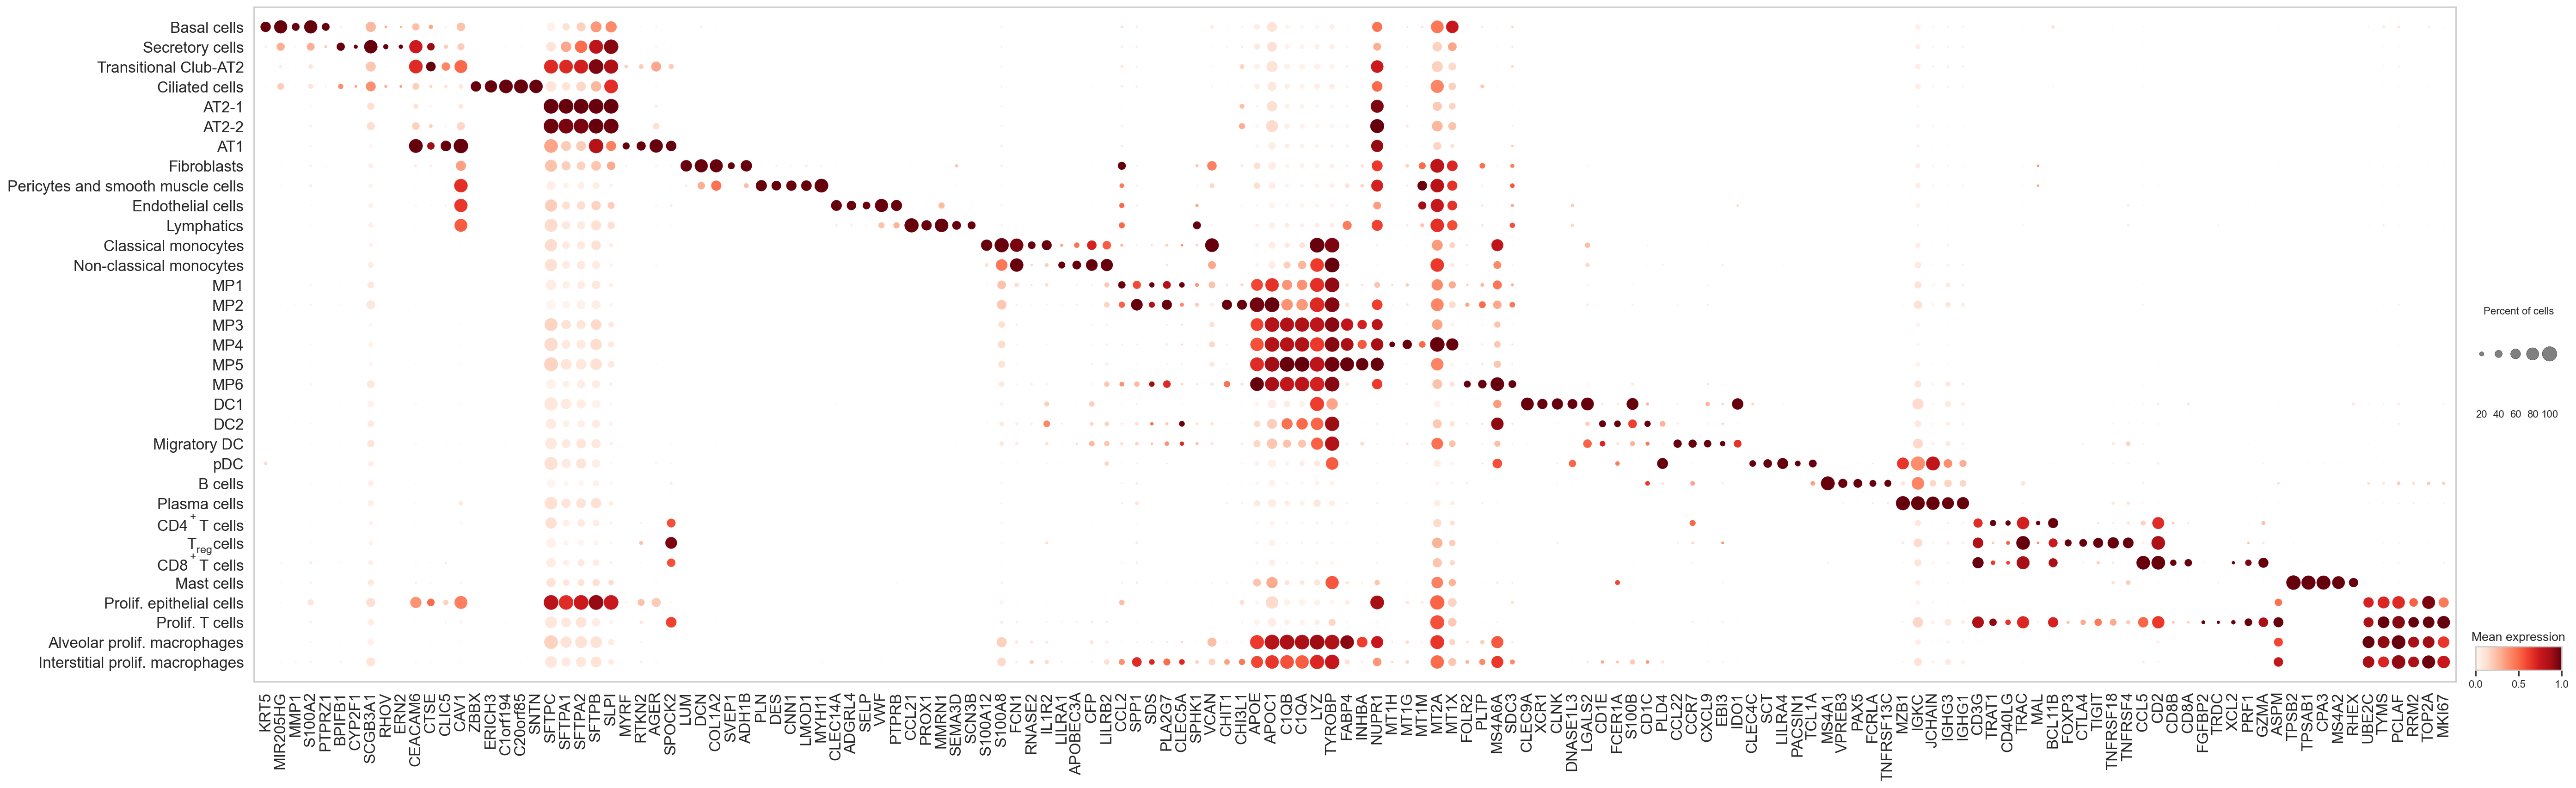

In [25]:
new_order = [
    'Basal cells', 'Secretory cells', 'Transitional Club-AT2', 'Ciliated cells', 
    'AT2-1', 'AT2-2', 'AT1', 'Fibroblasts', 'Pericytes and smooth muscle cells', 
    'Endothelial cells', 'Lymphatics', 'Classical monocytes', 'Non-classical monocytes', 
    'MP1', 'MP2', 'MP3', 'MP4', 'MP5', 'MP6', 'DC1', 'DC2', 'Migratory DC', 'pDC', 
    'B cells', 'Plasma cells', "$\\mathregular{{CD4}^+}$T cells", "$\mathregular{{T_{reg}}}$cells", 
    "$\mathregular{{CD8}^+}$T cells", 'NK + gdT cells', 'Mast cells', 'Prolif. epithelial cells', 
    'Prolif. T cells', 'Alveolar prolif. macrophages', 'Interstitial prolif. macrophages'
]

adata.obs['cell_type_pred'] = pd.Categorical(adata.obs['cell_type_pred'], categories=new_order, ordered=True)

dp = sc.pl.dotplot(
    adata,
    top_genes_reordered,
    groupby='cell_type_pred',
    swap_axes=False,
    figsize=(40, 12),
    standard_scale="var",
    edgecolor=None,
    show=False,
    zorder=2,
    return_fig=True,
    size_title="Percent of cells",
)

axes_dict = dp.get_axes()

main_ax = axes_dict['mainplot_ax']

for label in main_ax.get_xticklabels():
    label.set_fontsize(15)
    label.set_fontstyle('italic')  

for label in main_ax.get_yticklabels():
    label.set_fontsize(15)

color_legend_ax = axes_dict['color_legend_ax']
colorbar = color_legend_ax.collections[0].colorbar

colorbar_box = color_legend_ax.get_position()  
new_height = colorbar_box.height * 0.5  
new_bottom = colorbar_box.y0 + (colorbar_box.height - new_height) / 2
color_legend_ax.set_position([colorbar_box.x0, new_bottom, colorbar_box.width, new_height])

axes_dict['color_legend_ax'].set_title("Mean expression")

plt.savefig(f"/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/data/figures/fig_s5/fig_S5d.png", bbox_inches='tight')
plt.savefig(f"/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/data/figures/fig_s5/fig_S5d.pdf", bbox_inches='tight')